### Required Libs


In [2]:
"""
    File name: Plot_Utils.ipynb
    Author: Amin Abyaneh
    Email: aminabyaneh@gmail.com
    Date created: 25/04/2021
    Python Version: 3.8
    Description: Extracting the execution data by plots.
"""

# ========================================================================
# Copyright 2021, The CFL Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================


import os, sys
import pickle
import networkx as nx
from typing import List, Dict

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

def retrieve_client_info(stored_results_dict, metric='SHD', client_id='priors') -> np.ndarray:
    """ Return client results for a specific client id.
    
    Note: default is to return information for prior, or the end of the round results.
    """
    return np.asarray([client_dict[metric] for client_dict in stored_results_dict[client_id]])

def retrieve_adj_mats_per_round(stored_results_dict: Dict, rounds: List, client_id=-1) -> np.ndarray:
    """Return a list of adjacency matrices for a list of round ids.
    
    Note: default for client_id is -1 so that the method returns the aggregated adj mat at the end of each round,
    could be modified to client_id = {1.. num_clients} for retrieveing each client's adj matrix.
    """
    return [np.asarray(stored_results_dict['matrices'][round_id][client_id]) for round_id in rounds]


### Unbalanced Interventions locality method search for alpha



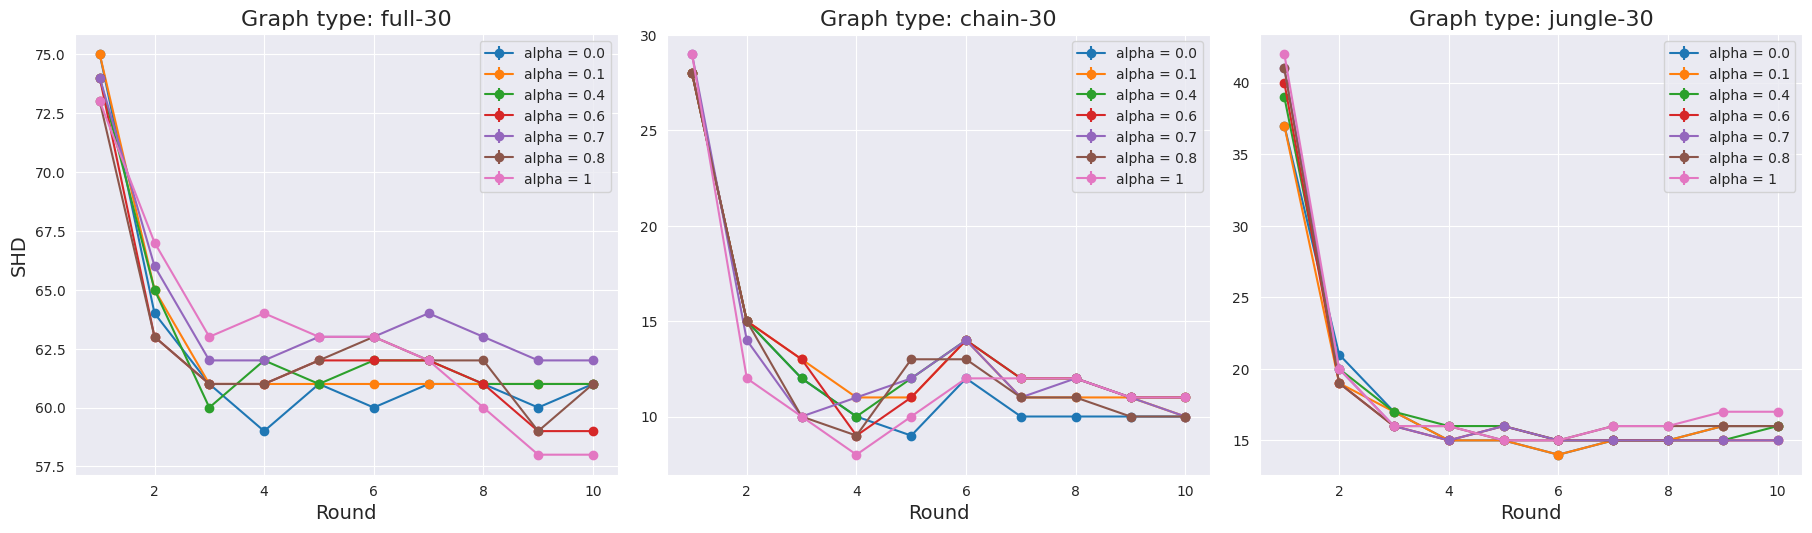

In [7]:
"""
We get a folder structure like this after running the experiments.

GraphAsym-chain-30/
"""

# Experiments
num_experiments = 8
repeat_count = 1
num_of_rounds = 10

# Graphs
graph_types = ["jungle"]
num_vars = 30

# Dataset size
num_clients = 2
intervention_models = ["0.0", "0.1", "0.2", "0.4", "0.6", 
                       "0.7", "0.8", "1"]

# Miscellaneous
plot_metric = "SHD"
std_exageration = 1
parent_folder_name = ""

# A list for rounds
rounds = np.arange(start=1, stop=num_of_rounds + 1, step=1)

n_row = 1
n_col = len(graph_types)

sns.set_style('darkgrid')

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 5), dpi=100, sharex='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

for idx, graph_type in enumerate(graph_types):
    
    ax_col = idx % 4
    axs[ax_col].set_title(f'Graph type: {graph_type}-{num_vars}', fontsize=16)
    folder_name = f'GraphAsym-{graph_type}-{num_vars}'

    for experiment_id in range(num_experiments):
        if experiment_id == 2: continue
        metrics = list()
        for rep_idx in range(repeat_count):
            data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
            load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

            with open(load_dir, 'rb') as handle:
                results_dict = pickle.load(handle)

            metrics.append(retrieve_client_info(results_dict, plot_metric))

        metrics_avg = np.mean(np.asarray(metrics), axis=0)
        metrics_std = np.std(np.asarray(metrics), axis=0)

        lab = f'alpha = {intervention_models[experiment_id]}'


        axs[ax_col].errorbar(rounds, metrics_avg, std_exageration * metrics_std, label=lab,
                                     linestyle='solid', marker='o')
        axs[ax_col].legend(loc='upper right')

    for r in range(n_row):
        axs[0].set_ylabel(plot_metric, fontsize=14)


    for c in range(n_col):
        axs[c].set_xlabel('Round', fontsize=14)

plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Toy experiments with structured graphs

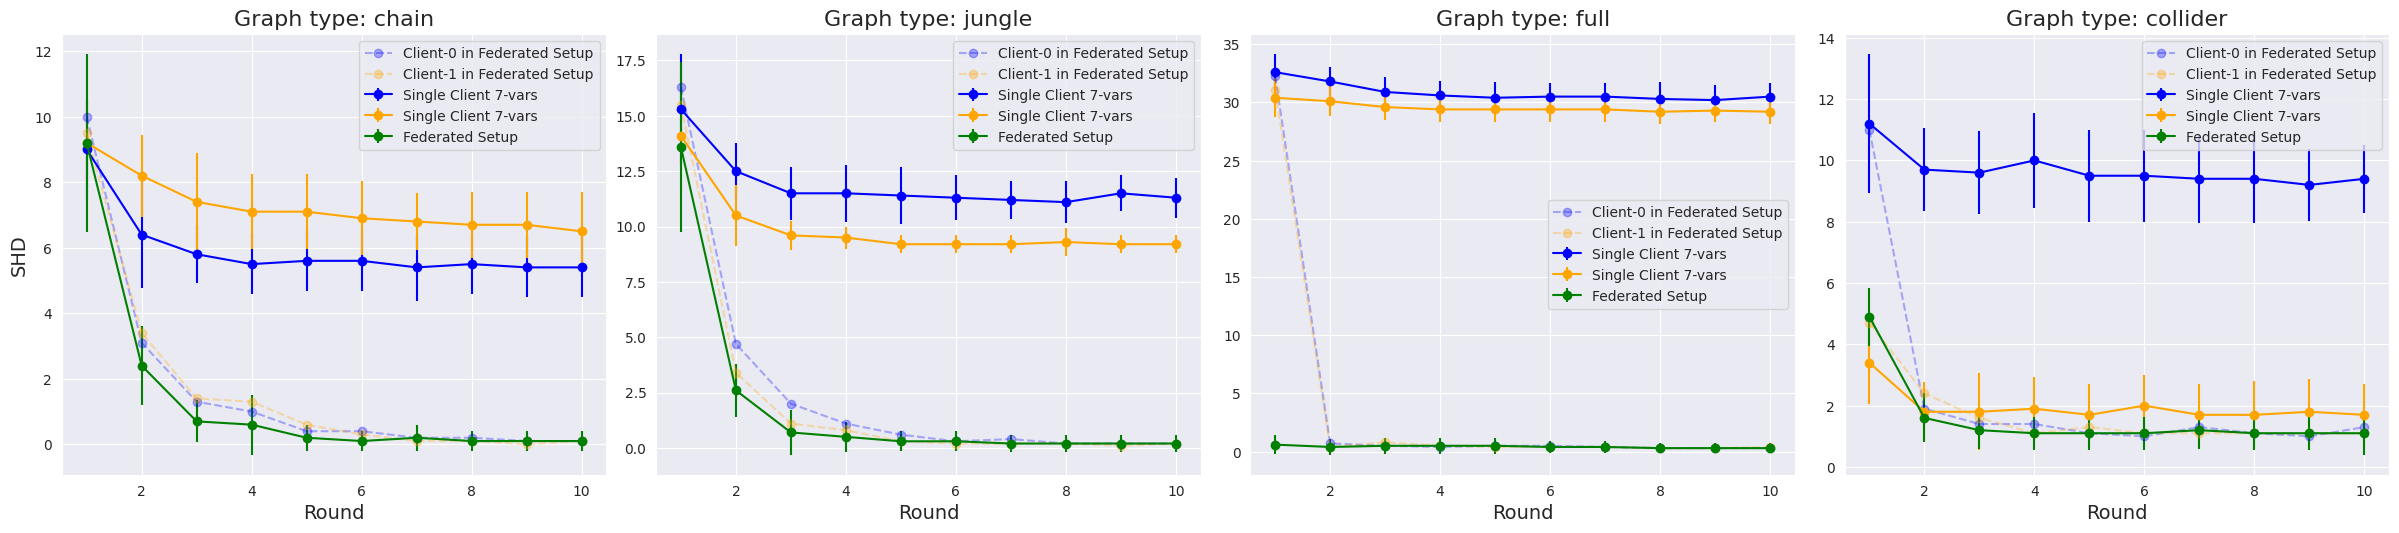

In [3]:
# Experiment setup
num_experiments = 3
num_of_rounds = 10
repeat_count = 10
num_clients = 2

# Graphs
num_vars = 15
graph_types = ["chain", "jungle", "full", "collider"]
intervention_models = ["Single Client 7-vars", "Single Client 7-vars", "Federated Setup"]

# Miscellaneous
plot_metric = "SHD"
plot_clients = True
std_exageration = 1
parent_folder_name = "str_toy/half"

colors = ["blue", "orange", "green"]
rounds = np.arange(start=1, stop=num_of_rounds + 1, step=1)

n_row = 1
n_col = len(graph_types)
sns.set_style('darkgrid')

fig, axs = plt.subplots(n_row, n_col, figsize=(24, 5), dpi=100, sharex='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

for idx, graph_type in enumerate(graph_types):
    ax_col = idx % n_col
    axs[ax_col].set_title(f'Graph type: {graph_type}', fontsize=16)
    folder_name = f'ToySetup-{graph_type}-{num_vars}'

    for experiment_id in range(num_experiments):
        metrics = list()
        client_1_metrics = list()
        client_0_metrics = list()
        for rep_idx in range(repeat_count):
            data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
            load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

            with open(load_dir, 'rb') as handle:
                results_dict = pickle.load(handle)
            
            metrics.append(retrieve_client_info(results_dict, plot_metric))
            if experiment_id == 2:
                client_0_metrics.append(retrieve_client_info(results_dict, plot_metric, 0))
                client_1_metrics.append(retrieve_client_info(results_dict, plot_metric, 1))

        metrics_avg = np.mean(np.asarray(metrics), axis=0)
        metrics_std = np.std(np.asarray(metrics), axis=0)
        
        if experiment_id == 2 and plot_clients:
            axs[ax_col].plot(rounds, np.mean(np.asarray(client_0_metrics), axis=0), label=f'Client-{0} in Federated Setup', linestyle='dashed', marker='o', color=colors[0], alpha=0.3)
            axs[ax_col].plot(rounds, np.mean(np.asarray(client_1_metrics), axis=0), label=f'Client-{1} in Federated Setup', linestyle='dashed', marker='o', color=colors[1], alpha=0.3)

        lab = f'{intervention_models[experiment_id]}'
        axs[ax_col].errorbar(rounds, metrics_avg, std_exageration * metrics_std, label=lab,
                                     linestyle='solid', marker='o', color=colors[experiment_id])
        axs[ax_col].legend(loc='best')

    for r in range(n_row):
        axs[0].set_ylabel(plot_metric, fontsize=14)

    for c in range(n_col):
        axs[ax_col].set_xlabel('Round', fontsize=14)

# plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Toy experiments random graph


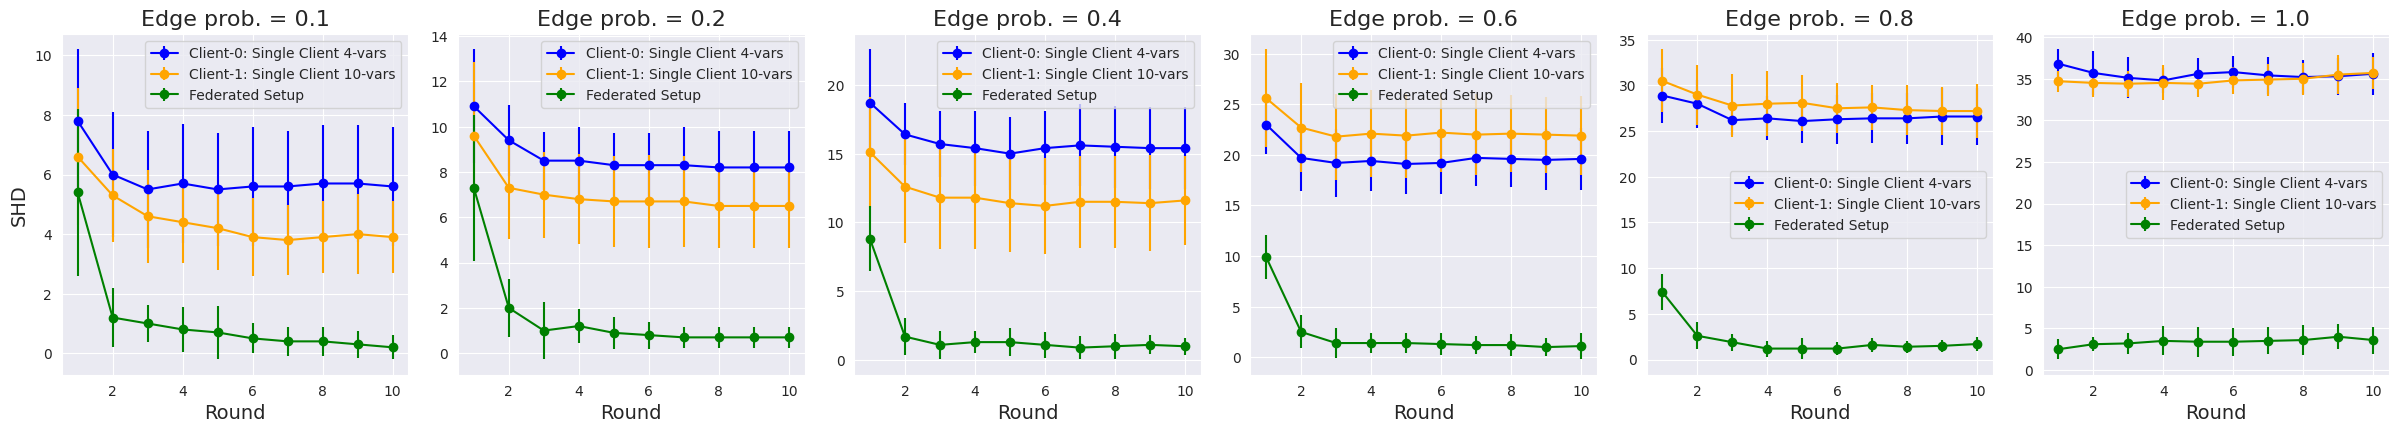

In [91]:
# Experiments
num_experiments = 3
num_of_rounds = 10
repeat_count = 10
num_clients = 2

# Graphs
graph_type = "random"
edge_probs = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
num_vars = 15
intervention_models = ["Client-0: Single Client 4-vars", "Client-1: Single Client 10-vars", "Federated Setup"]

# Miscellaneous
plot_metric = "SHD"
plot_clients = False
std_exageration = 1
parent_folder_name = "rnd_toy/half"

colors = ["blue", "orange", "green"]
rounds = np.arange(start=1, stop=num_of_rounds + 1, step=1)

n_row = 1
n_col = len(edge_probs)
sns.set_style('darkgrid')

fig, axs = plt.subplots(n_row, n_col, figsize=(24, 4), dpi=100, sharex='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

for idx, edge_prob in enumerate(edge_probs):
    ax_col = idx % n_col
    axs[ax_col].set_title(f'Edge prob. = {edge_prob}', fontsize=16)
    folder_name = f'ToySetup-{graph_type}-{num_vars}-{edge_prob}'

    for experiment_id in range(num_experiments):
        metrics = list()
        client_1_metrics = list()
        client_0_metrics = list()
        for rep_idx in range(repeat_count):
            data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
            load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

            with open(load_dir, 'rb') as handle:
                results_dict = pickle.load(handle)
            
            metrics.append(retrieve_client_info(results_dict, plot_metric))
            if experiment_id == 2:
                client_0_metrics.append(retrieve_client_info(results_dict, plot_metric, 0))
                client_1_metrics.append(retrieve_client_info(results_dict, plot_metric, 1))

        metrics_avg = np.mean(np.asarray(metrics), axis=0)
        metrics_std = np.std(np.asarray(metrics), axis=0)
        
        if experiment_id == 2 and plot_clients:
            axs[ax_col].plot(rounds, np.mean(np.asarray(client_0_metrics), axis=0), label=f'Client-{0} in Federated Setup', linestyle='dashed', marker='o', color=colors[0], alpha=0.3)
            axs[ax_col].plot(rounds, np.mean(np.asarray(client_1_metrics), axis=0), label=f'Client-{1} in Federated Setup', linestyle='dashed', marker='o', color=colors[1], alpha=0.3)

        lab = f'{intervention_models[experiment_id]}'
        axs[ax_col].errorbar(rounds, metrics_avg, std_exageration * metrics_std, label=lab,
                                     linestyle='solid', marker='o', color=colors[experiment_id])
        axs[ax_col].legend(loc='best')

    for r in range(n_row):
        axs[0].set_ylabel(plot_metric, fontsize=14)

    for c in range(n_col):
        axs[ax_col].set_xlabel('Round', fontsize=14)

# plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Plot graphs per round

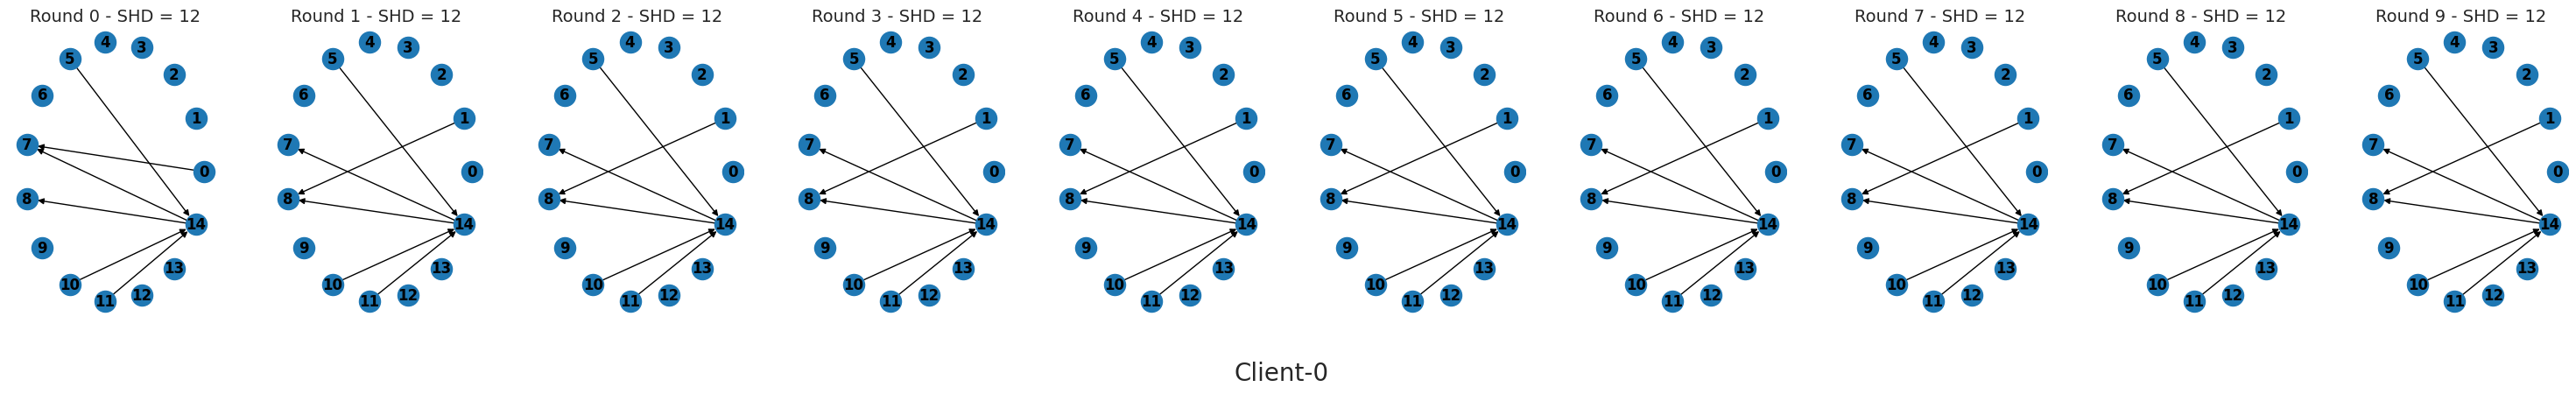

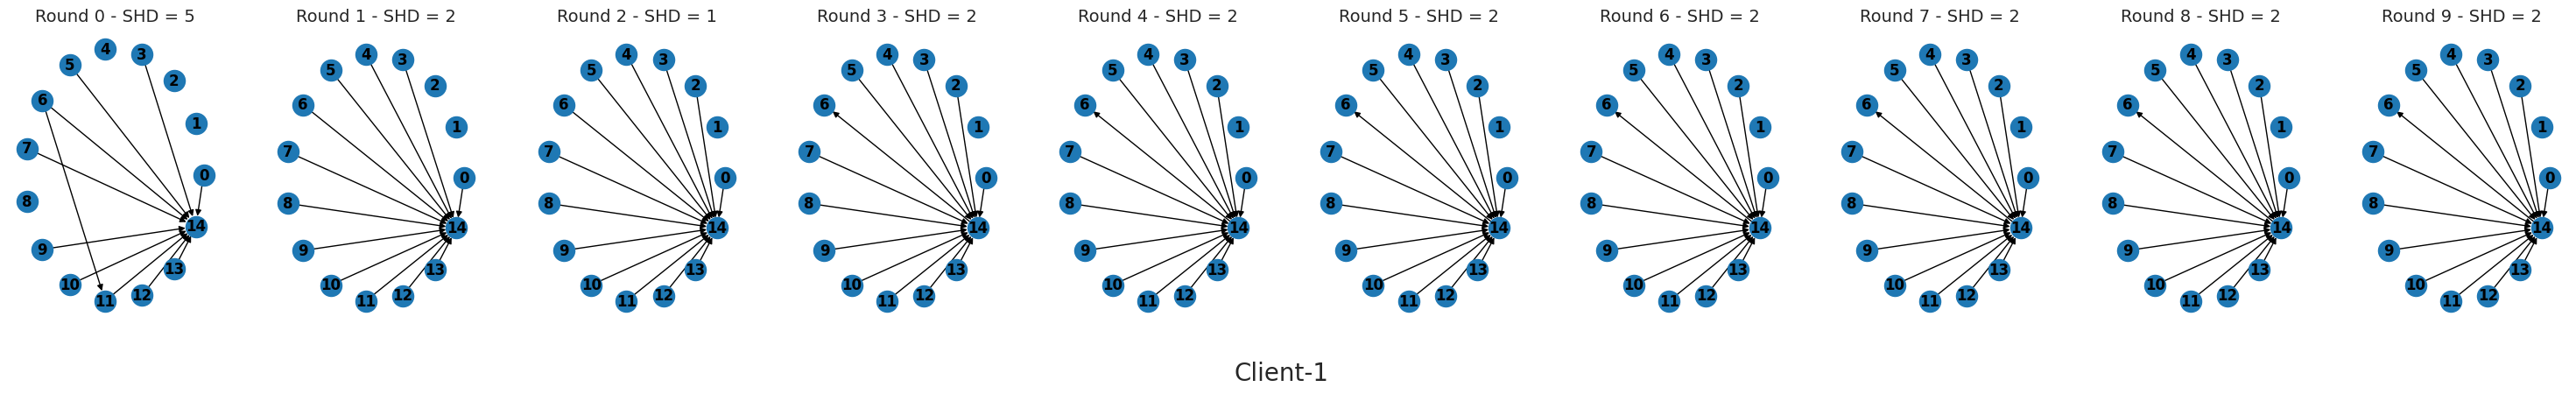

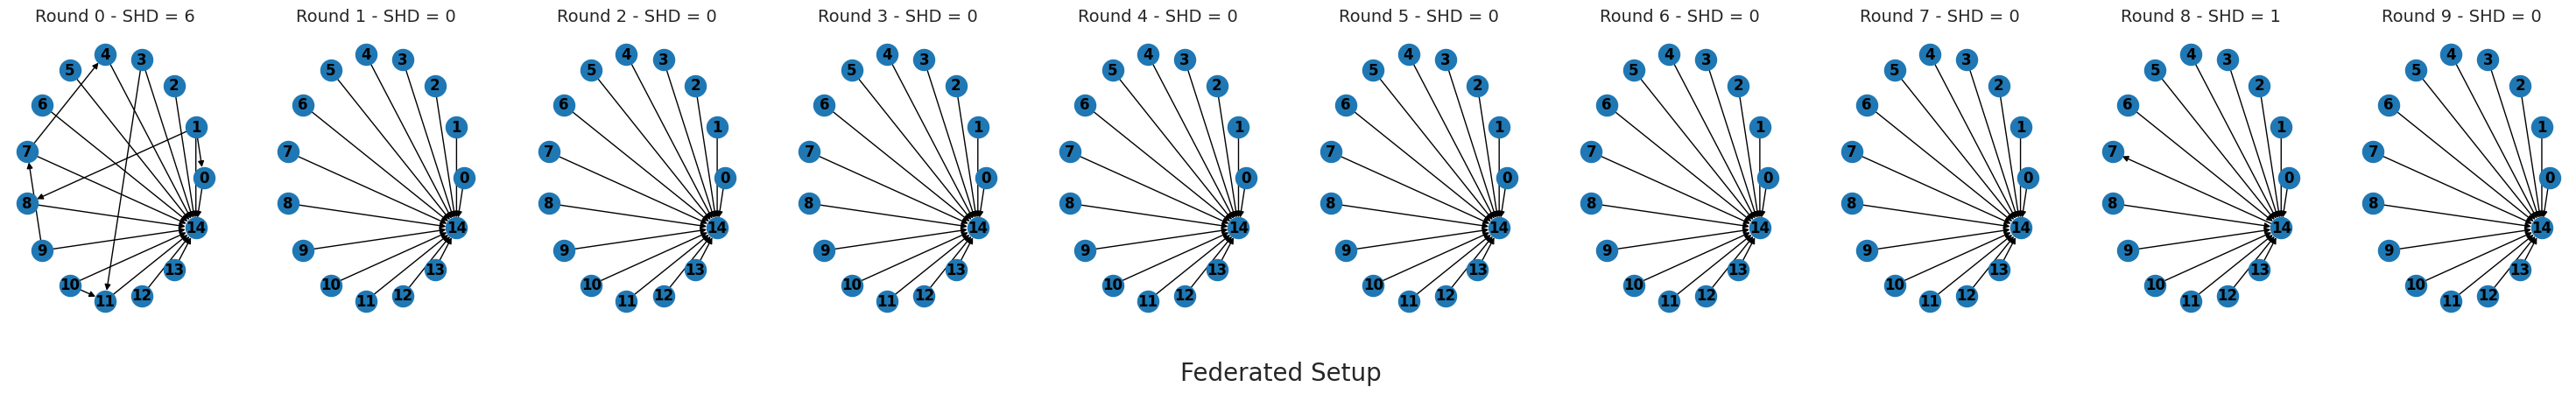

In [88]:
# Experiments
num_of_rounds = 10
rounds = np.arange(start=0, stop=num_of_rounds, step=1)
sns.set_style('darkgrid')


folder_name = "str_toy/unbl/ToySetup-collider-15"

for idx, setup in enumerate(["Client-0", "Client-1", "Federated Setup"]):
    data_file_name = f'results_{idx}_1.pickle'
    load_dir = os.path.join('data', folder_name, data_file_name)
    
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    setup_mats = retrieve_adj_mats_per_round(results_dict, rounds)
    client_id = 0 if setup != "Federated Setup" else 'priors'
    setup_shds = retrieve_client_info(results_dict, 'SHD', client_id)

    n_row = 1
    n_col = 10

    fig, axs = plt.subplots(n_row, n_col, figsize=(30, 4), dpi=100)
    fig.tight_layout(h_pad=2, w_pad=0.5)

    for c in range(n_col):
        graph = nx.DiGraph(setup_mats[c])
        nx.draw_circular(graph, ax=axs[c], with_labels=True, font_weight='bold')
        axs[c].set_title(f'Round {c} - SHD = {setup_shds[c]}', fontsize=14)
        axs[c].set_axis_off()

    fig.suptitle(setup, fontsize=20, y=0)
    plt.show()
    
